# MNIST Autoencoder

We will use the MNIST dataset of handwritten digits [http://yann.lecun.com/exdb/mnist/] first to explore what autoencoders do. To begin, we need to load some python modules including common layers from keras.

In [1]:

from tensorflow import keras
# MNIST dataset
from keras.datasets import mnist

# numpy and pyplot
import numpy as np
import matplotlib.pyplot as plt

# keras
import keras
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.layers import Conv2DTranspose, Concatenate, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


We prepare the data by normalizing it.

Sincle we are doing unsupervised learning here, we will not need the labels provided by the dataset for now. We keep them however, as they will help with visualizing the results later.

There are 60k training and 10k test examples.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
fashion_mnist = keras.datasets.fashion_mnist

#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(x_train, train_labels), (x_test, test_labels) = fashion_mnist.load_data()

In priciple, an autoencoder consists of two models: the encoder and the decoder. To represent this, we are using keras' functional API where we can easily define models from component models.

We start by defining the encoder, whose output will be the latent space of the model. This latent space shall contain
32 floats. Storing just this data would yield a compression factor of 24.5, as  the input consists of $28\cdot28 = 784$ floats. Practically it is four times less, as the original images were 8-bit grayscale.

Then we define the decoder, which takes the latent image as input and produces full-size images again.

Finally, we chain encoder and decoder together to get our autoencoder.

## Shallow Autoencoder
First, we try a very shallow autoencoder with only one dense layer for each, the encoder and decoder.

In [4]:
# this is the size of our encoded representations
encodingDim = 32  # 

# this is our input placeholder
inputImg = Input(shape=x_train.shape[1:])
# encoder
x = Flatten()(inputImg)
x = Dense(encodingDim, activation='relu')(x)
encoder = Model(inputImg, x, name="encoder")
encoder.summary()

# this is our latent space placeholder
inputLat = Input(shape=encoder.output.shape.as_list()[1:])
# decoder
x = Dense(int(np.prod(inputImg.shape[1:])), activation='sigmoid')(inputLat)
x = Reshape(inputImg.shape[1:])(x)
decoder = Model(inputLat, x, name="decoder")
decoder.summary()

# this model maps an input to its reconstruction
autoencoder = Model(inputImg, decoder(encoder(inputImg)), name="generator")
autoencoder.summary()

W1012 22:13:53.538926 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1012 22:13:53.556003 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1012 22:13:53.565644 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
_________________________________________________________________
reshap

In [5]:
# compile model using binary crossentropy loss
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

W1012 22:13:53.618165 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1012 22:13:53.638541 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1012 22:13:53.642795 35184372383184 deprecation.py:323] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

W1012 22:13:53.793436 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 42us/step - loss: -1063.5469 - val_loss: -1133.0501
Epoch 2/50
60000/60000 [==============================] - 1s 14us/step - loss: -1129.9010 - val_loss: -1133.2863
Epoch 3/50
60000/60000 [==============================] - 1s 14us/step - loss: -1130.0467 - val_loss: -1133.3864
Epoch 4/50
60000/60000 [==============================] - 1s 14us/step - loss: -1130.1771 - val_loss: -1133.5293
Epoch 5/50
60000/60000 [==============================] - 1s 14us/step - loss: -1130.3459 - val_loss: -1133.7597
Epoch 6/50
60000/60000 [==============================] - 1s 14us/step - loss: -1130.5420 - val_loss: -1133.9048
Epoch 7/50
60000/60000 [==============================] - 1s 14us/step - loss: -1131.4230 - val_loss: -1138.7747
Epoch 8/50
60000/60000 [==============================] - 1s 14us/step - loss: -1135.6013 - val_loss: -1138.9815
Epoch 9/50
60000/60000 [======================

Here we define a function to compare original and reconstructed images, which we will use later.

In [7]:
def showImages(ae, data):
    decoded_imgs = ae.predict(data)

    n = data.shape[0]  # how many digits we will display
    height = 20
    plt.figure(figsize=(height, height/n*2))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

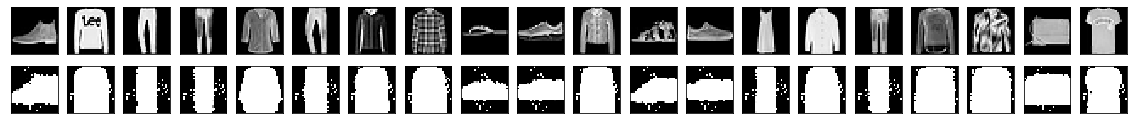

In [8]:
showImages(autoencoder, x_test[0:20])

## Multi-Layer Perceptron Autoencoder

Let us try a deeper network. This will have much more parameters as we use dense layers only, but it will give us better reconstructions after training for 50 epochs.

We will cut the latent space in half to get more compression (only use 16 float32 values), at the cost of some quality after traning only 50 epochs. So the improved reconstruction quality may not become a reality.

In [9]:
def makeDeepMLPAE(encodingDim=16):
    # this is our input placeholder
    inputImg = Input(shape=x_train.shape[1:])
    x = Flatten()(inputImg)
    # encoder
    x = Dense(encodingDim*16, activation='relu')(x)
    x = Dense(encodingDim*8, activation='relu')(x)
    x = Dense(encodingDim*4, activation='relu')(x)
    x = Dense(encodingDim, activation='relu')(x)
    encoder = Model(inputImg, x, name="encoder")
    encoder.summary()

    # this is our latent space placeholder
    inputLat = Input(shape=encoder.output.shape.as_list()[1:])
    #decoder
    x = Dense(encodingDim*4, activation='relu')(inputLat)
    x = Dense(encodingDim*8, activation='relu')(x)
    x = Dense(encodingDim*16, activation='relu')(x)
    x = Dense(int(np.prod(inputImg.shape[1:])), activation='sigmoid')(x)
    x = Reshape(inputImg.shape[1:])(x) # remove channel dimension
    decoder = Model(inputLat, x, name="decoder")
    decoder.summary()

    # this model maps an input to its reconstruction
    autoencoder = Model(inputImg, decoder(encoder(inputImg)), name="generator")
    autoencoder.summary()
    
    return encoder, decoder, autoencoder

In [10]:
encoder, decoder, autoencoder = makeDeepMLPAE(16)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
Total params: 243,152
Trainable params: 243,152
Non-trainable params: 0
_________________________________________________________________
____

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 37us/step - loss: -1111.3753 - val_loss: -1136.8028
Epoch 2/50
60000/60000 [==============================] - 2s 25us/step - loss: -1133.5805 - val_loss: -1136.8028
Epoch 3/50
60000/60000 [==============================] - 1s 25us/step - loss: -1133.5805 - val_loss: -1136.8028
Epoch 4/50
60000/60000 [==============================] - 1s 25us/step - loss: -1133.5805 - val_loss: -1136.8028
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: -1133.5805 - val_loss: -1136.8028
Epoch 6/50
60000/60000 [==============================] - 2s 26us/step - loss: -1133.5805 - val_loss: -1136.8028
Epoch 7/50
60000/60000 [==============================] - 2s 26us/step - loss: -1133.5805 - val_loss: -1136.8028
Epoch 8/50
60000/60000 [==============================] - 2s 25us/step - loss: -1133.5805 - val_loss: -1136.8028
Epoch 9/50
60000/60000 [======================

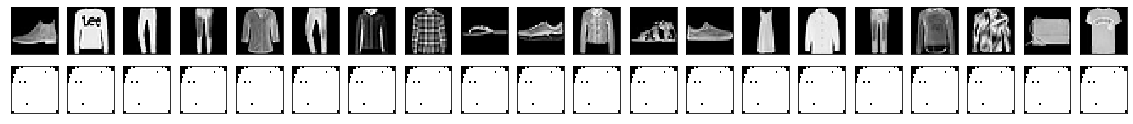

In [12]:
showImages(autoencoder, x_test[0:20])

The reconstructions we obtain are still decent. Of course, longer training could perhaps improve the results. After training for another 50 epochs we would get better reconstruction than with the shallow example above.

## Latent Space Representation

The autoencoder effectively takes the 784 dimensional input data and tries to represent it in a 16 dimensional space (a vector of 16 floats).

We can visualize the latent space only by looking at it in fewer, i.e. two, dimensions. To this end we can perfom a principal component analysis (PCA) on the encoded images, to find a transform to a coordinate system, where as much of the variance in the encoded data is happening on as few axes as possible. We can than pick the two most important ones to project all points in latent space onto this plane.

We use the labels, indicating the digit to color each point.

In [13]:
from sklearn.decomposition import PCA

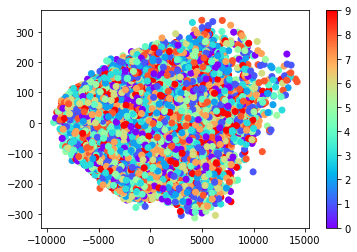

In [14]:
pca = PCA(n_components=2)
projection = pca.fit_transform(encoder.predict(x_test))
plt.scatter(projection[:,0], projection[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()

You see, that in this projection, the autoencoder apparently learned to separate between ones (blue) and zeros (violet) and has everything somewhere in between.

You can experiment with even smaller latent spaces, too.

We can also try to project on a 3D space:

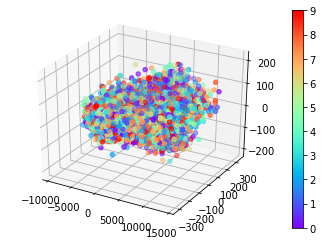

In [15]:
# try notbook mode so you can interactively rotate
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
projection = pca.fit_transform(encoder.predict(x_test))
p = ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=y_test, cmap="rainbow")
fig.colorbar(p)
fig.show()

In [16]:
# make sure to reset back to inline after trying notebook for 3D
%matplotlib inline

## Convolutional Autoencoder

Deep networks work well because of their ability to abstract. Going deeper with an MLP immensely increases the number of weight needing to be trained, leading to higher training cost and eventually overfitting.

So, we go to a convolutional autoencoder. We use a classical (AlexNet/GoogleNet) approach of using a set of convolutional units, extract features from the input image and use dense layers at the bottom to interpret these features. To produce an autoencoder we mirror the structure of the encoder in the decoder.

In this example we just use max-pooling in the encoder, upsampling in the decoder and standard 2D convolution throughout. An alternative would be to use strided 2D convolutions in the encoder and strided transpose 2D convolutions in the decoder.

Since our screen has only two dimensions, restrict the latent space to this, so we can better see what is going on. With this strong restriction we will not get as good reconstructions as before, but this more powerfull architecture should help us to still get something decent.

This network has much fewer trainable parameters than the previous one.

In [17]:
# this is the size of our encoded representations
encodingDim = 2

# this is our input placeholder
inputImg = Input(shape=x_train.shape[1:])

# "encoded" is the encoded representation of the input
x = Reshape((*inputImg.shape.as_list()[1:],1))(inputImg)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
cshape = x.shape.as_list()[1:]
x = Flatten()(x)
x = Dense(encodingDim*16, activation='relu')(x)
x = Dense(encodingDim*8, activation='relu')(x)
x = Dense(encodingDim*4, activation='relu')(x)
x = Dense(encodingDim, activation='relu')(x)
encoder = Model(inputImg, x, name="encoder")
encoder.summary()

# "decoded" is the lossy reconstruction of the input
inputLat = Input(shape=encoder.output.shape.as_list()[1:])
x = Dense(encodingDim*4, activation='relu')(inputLat)
x = Dense(encodingDim*8, activation='relu')(inputLat)
x = Dense(encodingDim*16, activation='relu')(inputLat)
x = Dense(int(np.prod(cshape)), activation='relu')(x)
x = Reshape(cshape)(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = UpSampling2D(size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = UpSampling2D(size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding="same")(x)
x = Reshape(inputImg.shape.as_list()[1:])(x)

decoder = Model(inputLat, x, name="decoder")
decoder.summary()

# this model maps an input to its reconstruction
autoencoder = Model(inputImg, decoder(encoder(inputImg)), name="generator")
autoencoder.summary()

W1012 22:16:02.021333 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1012 22:16:02.028732 35184372383184 deprecation.py:506] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1012 22:16:02.231975 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 4)         148       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         296       
__________

In [18]:
opt = keras.optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

In [19]:
autoencoder.fit(x_train, x_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 6s 92us/step - loss: -826.8270 - val_loss: -1150.1884
Epoch 2/40
60000/60000 [==============================] - 3s 48us/step - loss: -1146.9100 - val_loss: -1150.1923
Epoch 3/40
60000/60000 [==============================] - 3s 48us/step - loss: -1146.9213 - val_loss: -1150.2286
Epoch 4/40
60000/60000 [==============================] - 3s 48us/step - loss: -1146.9566 - val_loss: -1150.3214
Epoch 5/40
60000/60000 [==============================] - 3s 48us/step - loss: -1147.0804 - val_loss: -1150.4350
Epoch 6/40
60000/60000 [==============================] - 3s 48us/step - loss: -1147.1384 - val_loss: -1150.4973
Epoch 7/40
60000/60000 [==============================] - 3s 48us/step - loss: -1147.1560 - val_loss: -1150.4870
Epoch 8/40
60000/60000 [==============================] - 3s 48us/step - loss: -1147.1763 - val_loss: -1150.5060
Epoch 9/40
60000/60000 [=======================

Now we can look at the latent space directly.

We can see, that the encoder learned to decompse each digit into ints "one-ness" and its "zero-ness".

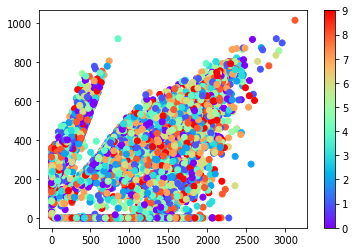

In [20]:
%matplotlib inline

encoded = encoder.predict(x_test)
plt.scatter(encoded[:,0], encoded[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()

As we can guess from the higher loss, the reconstructions are less good then before. Notably, one can see, that this model seems to deny the existence of the digit "4" and always encodes these it as "9" instead.

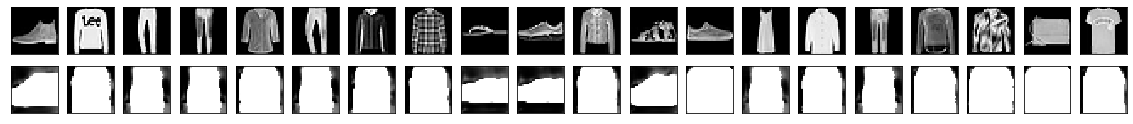

In [21]:
showImages(autoencoder, x_test[0:20])

We can train for more epochs to get slighlty better results. Doing this we can observe, that the separation between the classes in latent space improves.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 48us/step - loss: -1150.2173 - val_loss: -1152.9822
Epoch 2/20
60000/60000 [==============================] - 3s 48us/step - loss: -1150.3720 - val_loss: -1154.2150
Epoch 3/20
60000/60000 [==============================] - 3s 48us/step - loss: -1150.9393 - val_loss: -1154.5133
Epoch 4/20
60000/60000 [==============================] - 3s 48us/step - loss: -1151.0260 - val_loss: -1154.3953
Epoch 5/20
60000/60000 [==============================] - 3s 48us/step - loss: -1151.0705 - val_loss: -1154.4866
Epoch 6/20
60000/60000 [==============================] - 3s 48us/step - loss: -1151.0833 - val_loss: -1154.6938
Epoch 7/20
60000/60000 [==============================] - 3s 48us/step - loss: -1151.1574 - val_loss: -1154.7409
Epoch 8/20
60000/60000 [==============================] - 3s 48us/step - loss: -1150.9193 - val_loss: -1154.6835
Epoch 9/20
60000/60000 [======================

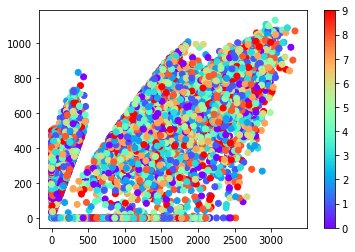

In [22]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded = encoder.predict(x_test)
plt.scatter(encoded[:,0], encoded[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()

We can also sample this latent space and generate numbers from latent space vectors. Although not all regions of the latent space necessarily yield contain valid representations of digits and produce sensible output.

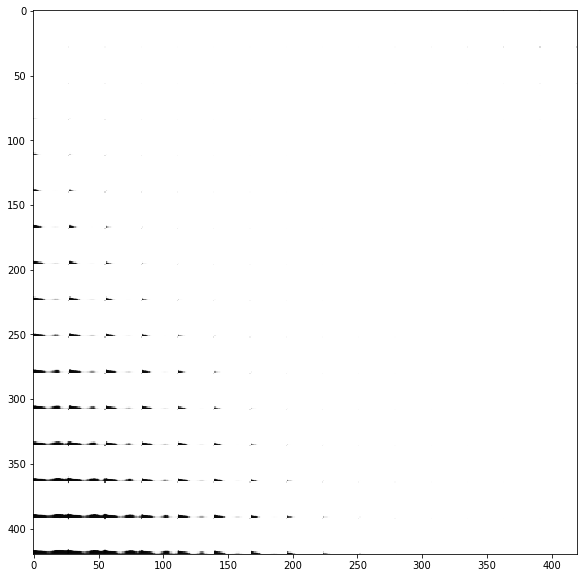

In [23]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 10, n)
grid_y = np.linspace(0, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.gray()
plt.show()

## Inception-like

In [24]:
def InceptionLike(encodingDim = 2):

    # this is our input placeholder
    inputImg = Input(shape=x_train.shape[1:])

    def inception(bottom, nfilters):
        pool = MaxPooling2D(pool_size=(2,2))(bottom)
        c3 = Conv2D(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2))(bottom)
        c5 = Conv2D(nfilters, kernel_size=(5, 5), activation='relu', padding="same", strides=(2,2))(bottom)
        c6 = Conv2D(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(1,1))(bottom)
        c6 = Conv2D(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2))(c6)
        x = Concatenate()([pool, c3, c5, c6])
        return Conv2D(nfilters*2, kernel_size=(1, 1), activation='relu', padding="same")(x)

    # "encoded" is the encoded representation of the input
    x = Reshape((*inputImg.shape.as_list()[1:],1))(inputImg)
    x = inception(x, 8)
    #x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = inception(x, 16)
    #x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same")(x)
    x = Conv2D(8, kernel_size=(1, 1), activation='relu', padding="same")(x)

    cshape = x.shape.as_list()[1:]
    x = Flatten()(x)
    x = Dense(encodingDim*16, activation='relu')(x)
    x = Dense(encodingDim*8, activation='relu')(x)
    #x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Dense(encodingDim*4, activation='relu')(x)
    x = Dense(encodingDim, activation='relu')(x)
    encoder = Model(inputImg, x, name="encoder")
    encoder.summary()

    def deception(bottom, nfilters):
        pool = UpSampling2D(size=(2,2))(bottom)
        c3 = Conv2DTranspose(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2))(bottom)
        c5 = Conv2DTranspose(nfilters, kernel_size=(5, 5), activation='relu', padding="same", strides=(2,2))(bottom)
        c6 = Conv2DTranspose(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(1,1))(bottom)
        c6 = Conv2DTranspose(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2))(c6)
        x = Concatenate()([pool, c3, c5, c6])
        return Conv2D(nfilters*2, kernel_size=(1, 1), activation='relu', padding="same")(x)

    # "decoded" is the lossy reconstruction of the input
    inputLat = Input(shape=encoder.output.shape.as_list()[1:])
    x = Dense(encodingDim*4, activation='relu')(inputLat)
    x = Dense(encodingDim*8, activation='relu')(inputLat)
    x = Dense(encodingDim*16, activation='relu')(inputLat)
    #x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Dense(int(np.prod(cshape)), activation='relu')(x)
    x = Reshape(cshape)(x)

    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same")(x)
    x = deception(x, 16)
    #x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = deception(x, 8)
    x = Conv2D(1, kernel_size=(1, 1), activation='relu', padding="same")(x)

    x = Reshape(inputImg.shape.as_list()[1:])(x)

    decoder = Model(inputLat, x, name="decoder")
    decoder.summary()

    # this model maps an input to its reconstruction
    autoencoder = Model(inputImg, decoder(encoder(inputImg)), name="generator")
    autoencoder.summary()
    
    return autoencoder,encoder,decoder

In [25]:
inceptionAE, inceptionE, inceptionD = InceptionLike()

W1012 22:19:04.220513 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 28, 28, 1)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 28, 28, 8)    80          reshape_6[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 1)    0           reshape_6[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

In [26]:
opt = keras.optimizers.Adam(lr=0.00005)
inceptionAE.compile(optimizer=opt, loss='binary_crossentropy')

In [27]:
inceptionAE.fit(x_train, x_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 11s 177us/step - loss: 633.9400 - val_loss: 437.1520
Epoch 2/40
60000/60000 [==============================] - 7s 119us/step - loss: 279.6371 - val_loss: 56.8600
Epoch 3/40
60000/60000 [==============================] - 7s 117us/step - loss: -268.9881 - val_loss: -498.6312
Epoch 4/40
60000/60000 [==============================] - 7s 119us/step - loss: -636.0671 - val_loss: -773.3256
Epoch 5/40
60000/60000 [==============================] - 7s 119us/step - loss: -801.9250 - val_loss: -892.4204
Epoch 6/40
60000/60000 [==============================] - 7s 117us/step - loss: -906.4105 - val_loss: -960.8522
Epoch 7/40
60000/60000 [==============================] - 7s 119us/step - loss: -983.1843 - val_loss: -1030.1007
Epoch 8/40
60000/60000 [==============================] - 7s 118us/step - loss: -1036.5699 - val_loss: -1067.8333
Epoch 9/40
60000/60000 [==============================]

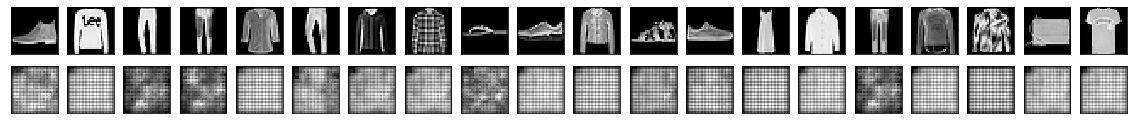

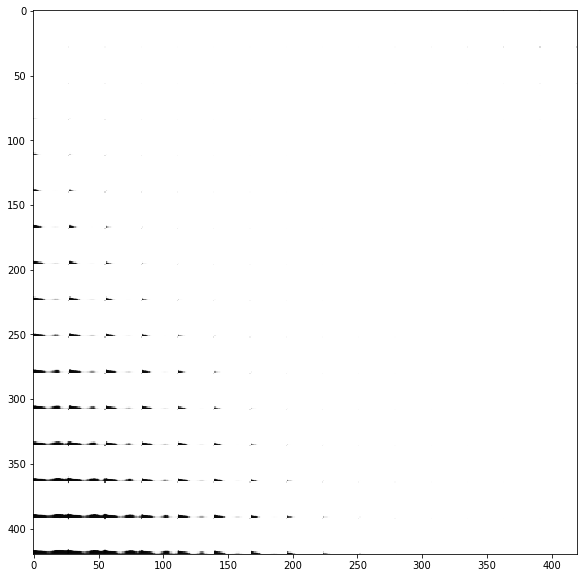

In [28]:
showImages(inceptionAE, x_test[0:20])
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 10, n)
grid_y = np.linspace(0, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.gray()
plt.show()

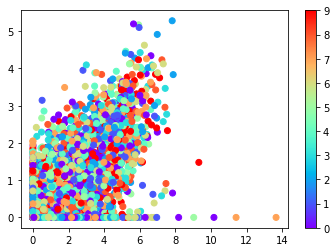

In [29]:
%matplotlib inline

encoded = inceptionE.predict(x_test)
plt.scatter(encoded[:,0], encoded[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()



Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 119us/step - loss: -1146.9749 - val_loss: -1150.2690
Epoch 2/20
60000/60000 [==============================] - 7s 118us/step - loss: -1146.9866 - val_loss: -1150.2957
Epoch 3/20
60000/60000 [==============================] - 7s 118us/step - loss: -1147.0068 - val_loss: -1150.3078
Epoch 4/20
60000/60000 [==============================] - 7s 118us/step - loss: -1147.0233 - val_loss: -1150.3333
Epoch 5/20
60000/60000 [==============================] - 7s 119us/step - loss: -1147.0391 - val_loss: -1150.3428
Epoch 6/20
60000/60000 [==============================] - 7s 118us/step - loss: -1147.0502 - val_loss: -1150.3490
Epoch 7/20
60000/60000 [==============================] - 7s 119us/step - loss: -1147.0599 - val_loss: -1150.3155
Epoch 8/20
60000/60000 [==============================] - 7s 118us/step - loss: -1147.0818 - val_loss: -1150.3737
Epoch 9/20
60000/60000 [==============

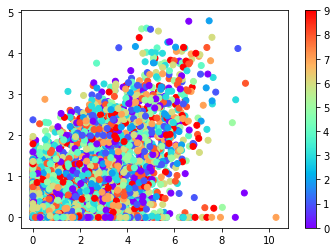

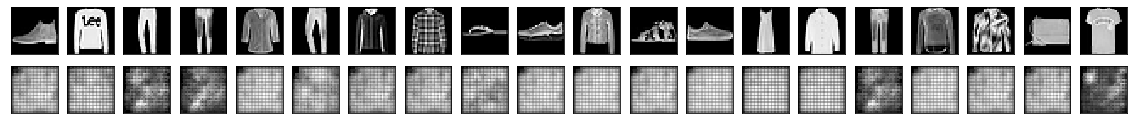

In [30]:
inceptionAE.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded = inceptionE.predict(x_test)
plt.scatter(encoded[:,0], encoded[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()

showImages(inceptionAE, x_test[0:20])

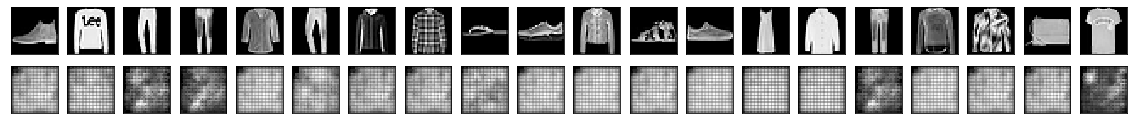

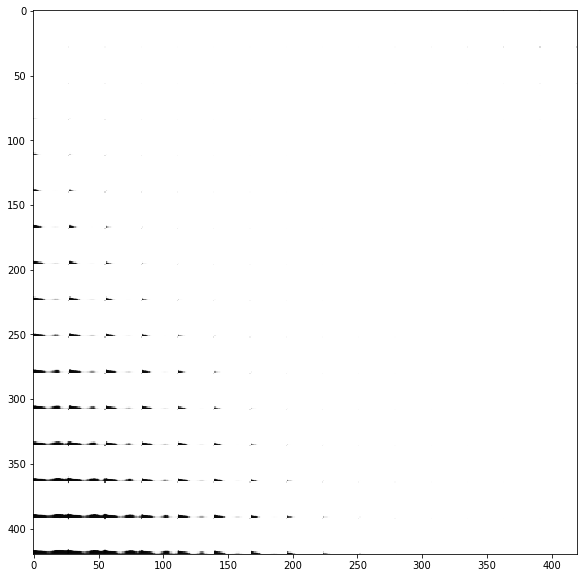

In [31]:
showImages(inceptionAE, x_test[0:20])

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 10, n)
grid_y = np.linspace(0, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.gray()
plt.show()

## Dense Inception Units

This is a very deep netowrk connecting inception units without down sampling like in a dense network and downsampling using normal inception units. There is still a small MLP around the bottleneck.

In [32]:
def inceptionDenseMLP(encodingDim = 2):

    # this is our input placeholder
    inputImg = Input(shape=x_train.shape[1:])

    def inception(bottom, nfilters, strides=(2,2)):
        pool = MaxPooling2D(pool_size=(2,2), strides=strides, padding="same")(bottom)
        c3 = Conv2D(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=strides)(bottom)
        c5 = Conv2D(nfilters, kernel_size=(5, 5), activation='relu', padding="same", strides=strides)(bottom)
        c6 = Conv2D(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(1,1))(bottom)
        c6 = Conv2D(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=strides)(c6)
        x = Concatenate()([pool, c3, c5, c6])
        return Conv2D(nfilters*2, kernel_size=(1, 1), activation='relu', padding="same")(x)

    def inceptionDense(bottom, nfilters):
        before = []
        x = bottom
        for f in nfilters:
            x = inception(x, f, (1,1))
            before.append(x)
            if len(before) > 1:
                x = Concatenate()(before)
            x = Conv2D(f*2, kernel_size=(1, 1), activation='relu', padding="same")(x)

        return x

    # "encoded" is the encoded representation of the input
    x = Reshape((*inputImg.shape.as_list()[1:],1))(inputImg)
    x = inceptionDense(x, [16,8,16,8])
    x = inception(x, 8)
    x = BatchNormalization()(x)
    x = inceptionDense(x, [32,16,8,32,16])
    x = inception(x, 16)
    x = BatchNormalization()(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same")(x)
    x = Conv2D(8, kernel_size=(1, 1), activation='relu', padding="same")(x)

    cshape = x.shape.as_list()[1:]
    x = Flatten()(x)
    x = Dense(encodingDim*16, activation='relu')(x)
    x = Dense(encodingDim*8, activation='relu')(x)
    #x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Dense(encodingDim*4, activation='relu')(x)
    x = Dense(encodingDim, activation='relu')(x)
    encoder = Model(inputImg, x, name="encoder")
    encoder.summary()

    def deception(bottom, nfilters):
        pool = UpSampling2D(size=(2,2))(bottom)
        c3 = Conv2DTranspose(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2))(bottom)
        c5 = Conv2DTranspose(nfilters, kernel_size=(5, 5), activation='relu', padding="same", strides=(2,2))(bottom)
        c6 = Conv2DTranspose(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(1,1))(bottom)
        c6 = Conv2DTranspose(nfilters, kernel_size=(3, 3), activation='relu', padding="same", strides=(2,2))(c6)
        x = Concatenate()([pool, c3, c5, c6])
        return Conv2D(nfilters*2, kernel_size=(1, 1), activation='relu', padding="same")(x)

    # "decoded" is the lossy reconstruction of the input
    inputLat = Input(shape=encoder.output.shape.as_list()[1:])
    x = Dense(encodingDim*4, activation='relu')(inputLat)
    x = Dense(encodingDim*8, activation='relu')(inputLat)
    x = Dense(encodingDim*16, activation='relu')(inputLat)
    x = BatchNormalization()(x)
    x = Dense(int(np.prod(cshape)), activation='relu')(x)
    x = Reshape(cshape)(x)

    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same")(x)
    x = deception(x, 16)
    x = inceptionDense(x, [8,16,32,8,16,32])
    x = BatchNormalization()(x)
    x = deception(x, 8)
    x = inceptionDense(x, [8,16,8,16,8])
    x = Conv2D(1, kernel_size=(1, 1), activation='relu', padding="same")(x)

    x = Reshape(inputImg.shape.as_list()[1:])(x)

    decoder = Model(inputLat, x, name="decoder")
    decoder.summary()

    # this model maps an input to its reconstruction
    autoencoder = Model(inputImg, decoder(encoder(inputImg)), name="generator")
    autoencoder.summary()
    
    return autoencoder, encoder, decoder

In [33]:
idAE, idE, idD = inceptionDenseMLP()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 28, 28, 1)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 28, 28, 16)   160         reshape_9[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 28, 28, 1)    0           reshape_9[0][0]                  
__________________________________________________________________________________________________
conv2d_27 

We start training with a learning rate of 0.001.

In [34]:
opt = keras.optimizers.Adam(lr=0.0001)
idAE.compile(optimizer=opt, loss='binary_crossentropy')

Even though it only has ~666k weights it is very slow because it has many units in sequence. We set the batchsize as large as the GPU memory permits to maximize throughput.

Training takes about 1min per epoch. The model can reach the performance of the convnet above in about 20. I can be trained much longer and grapually improves if the learning rate is annealed over time. Try annealing the learning rate by a factor of ~0.5 when the validation loss stops improving, but use high patience with that (>10 epochs).

During training the loss often suddenly increases, to then fall again over some epochs, usually reaching a new minimum before increasing again, when a new path is tried.

In [35]:
idAE.fit(x_train, x_train,
                epochs=200,
                batch_size=640,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[EarlyStopping(min_delta=1e-4, patience=20)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 41s 683us/step - loss: -445.5845 - val_loss: -1147.8789
Epoch 2/200
60000/60000 [==============================] - 26s 427us/step - loss: -1146.4250 - val_loss: -1148.9813
Epoch 3/200
60000/60000 [==============================] - 26s 428us/step - loss: -1146.8298 - val_loss: -1150.0624
Epoch 4/200
60000/60000 [==============================] - 26s 427us/step - loss: -1146.9057 - val_loss: -1150.1972
Epoch 5/200
60000/60000 [==============================] - 26s 426us/step - loss: -1146.9219 - val_loss: -1150.2170
Epoch 6/200
60000/60000 [==============================] - 26s 427us/step - loss: -1146.9208 - val_loss: -1150.2151
Epoch 7/200
60000/60000 [==============================] - 26s 428us/step - loss: -1146.9267 - val_loss: -1150.2269
Epoch 8/200
60000/60000 [==============================] - 26s 427us/step - loss: -1146.9195 - val_loss: -1150.2439
Epoch 9/200
60000/60000

In [36]:
idAE.save_weights("idAE194.h5")

After a few hours (~170 epochs) it can reach a validation loss of ~0.161, where it slowly starts to even accept the concept of "4".  

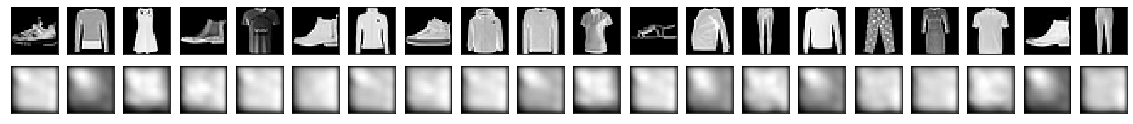

In [37]:
showImages(idAE, x_test[160:180])

We see a quite nice clustering of examples with the same labels in our 2D latent space.

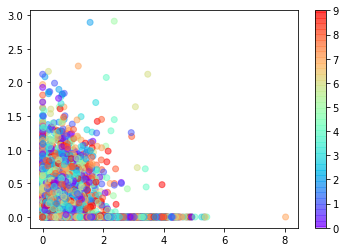

In [38]:
%matplotlib inline

encoded = idE.predict(x_test)
plt.scatter(encoded[:,0], encoded[:,1], c=y_test, cmap="rainbow", alpha=0.5)
plt.colorbar()
plt.show()

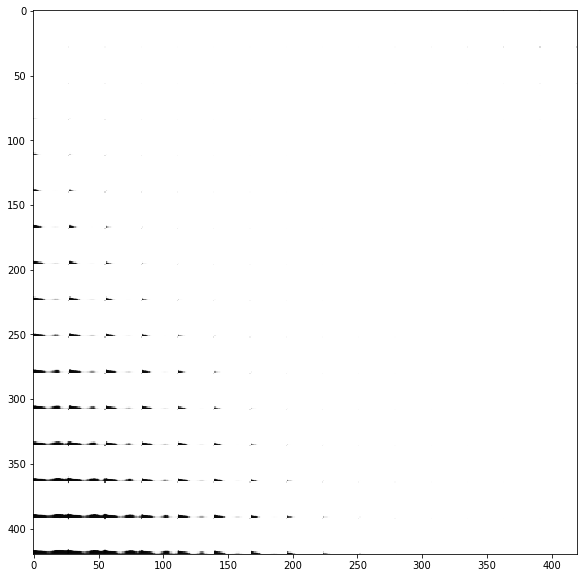

In [39]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 10, n)
grid_y = np.linspace(0, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.gray()
plt.show()

In [ ]:
pca = PCA(n_components=2)
projection = pca.fit_transform(encoder.predict(x_test))
plt.scatter(projection[:,0], projection[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()

### PLEASE RUN THIS COMMAND IF YOU FINISHED THE NOTEBOOK

In [ ]:
import os
temp=os.getpid()
# !kill -9 $temp